In [1]:
from unet_project.image_utils import ImageUtils
from unet_project.data_augmentation import DataAugmentation
from unet_project.u_net import Unet
from unet_project.create_patches import PatchesCreator
from skimage.io import imshow
from matplotlib import pyplot as plt
import numpy as np
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
from matplotlib import pyplot as plt
import random
from keras.models import load_model
from tqdm import tqdm_notebook
from scipy.signal import medfilt2d

Using TensorFlow backend.


## Load images 
- without augmentation
- create patches
- convert to scale 0 - 1
- split to train and test data

In [2]:
path_to_imgs = '/home/ajuska/Dokumenty/Skola/diplomka/test_folder/imgs/'
path_to_masks = '/home/ajuska/Dokumenty/Skola/diplomka/test_folder/masks/'
img_height = 224
img_width = 224
img_channels = 3

image_utils = ImageUtils(path_to_imgs, path_to_masks, img_height, img_width, architecture='unet')
imgs_masks = image_utils.get_preprocessed_images()

# data_augmentor = DataAugmentation(imgs_masks, how_many=1)
# aug_imgs, aug_masks = data_augmentor.extend_database()

imgs = []
masks = []
for key, val in tqdm_notebook(imgs_masks.items()):
    imgs.append(val[0])
    masks.append(val[1])

patches_creator = PatchesCreator(imgs, masks, img_height, img_width)
img_p, mask_p = patches_creator.create_patches()

 40%|████      | 16/40 [00:00<00:00, 154.87it/s]

Loading images.


100%|██████████| 40/40 [00:00<00:00, 79.37it/s] 



Loading masks.


 15%|█▌        | 6/40 [00:00<00:00, 55.74it/s]


Preprocessing images.


100%|██████████| 40/40 [00:00<00:00, 70.74it/s]



Creating patches.


In [3]:
trainX = np.array([x/255 for x in img_p])
trainY = np.array([x/255 for x in mask_p])

In [4]:
train_imgs = trainX[:int(0.95*len(trainX))]
train_masks = trainY[:int(0.95*len(trainY))]

test_imgs = trainX[int(0.95*len(trainX)):]
test_masks = trainY[int(0.95*len(trainY)):]

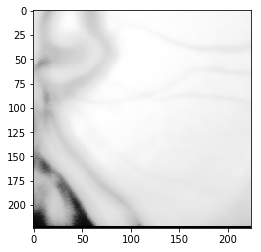

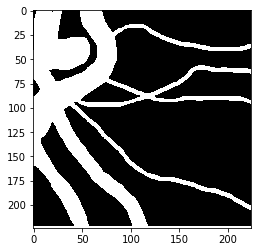

In [5]:
plt.figure()
plt.imshow(train_imgs[102])
plt.figure()
plt.imshow(np.squeeze(train_masks[102]), cmap='gray')

## Fit model
- create define model UNET
- set parameters 
- save trained model
- display validation loss during training network

In [ ]:
unet = Unet(img_height=img_height, img_width=img_width, img_channels=img_channels)
model = unet.create_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_vessels.h5', verbose=1, save_best_only=True)
results = model.fit(train_imgs, train_masks, validation_split=0.1, batch_size=16, epochs=50,
                    callbacks=[earlystopper, checkpointer])

Creating model.
Train on 513 samples, validate on 57 samples
Epoch 1/50
513/513 [==============================] - 315s 614ms/step - loss: 0.4879 - acc: 0.8074 - val_loss: 0.4150 - val_acc: 0.8665

Epoch 00001: val_loss improved from inf to 0.41497, saving model to model_unet_vessels.h5
Epoch 2/50
513/513 [==============================] - 314s 611ms/step - loss: 0.4384 - acc: 0.8613 - val_loss: 0.3831 - val_acc: 0.8730

Epoch 00002: val_loss improved from 0.41497 to 0.38308, saving model to model_unet_vessels.h5
Epoch 3/50
513/513 [==============================] - 363s 707ms/step - loss: 0.4128 - acc: 0.8649 - val_loss: 0.3609 - val_acc: 0.8754

Epoch 00003: val_loss improved from 0.38308 to 0.36095, saving model to model_unet_vessels.h5
Epoch 4/50
513/513 [==============================] - 424s 826ms/step - loss: 0.3950 - acc: 0.8647 - val_loss: 0.3438 - val_acc: 0.8760

Epoch 00004: val_loss improved from 0.36095 to 0.34379, saving model to model_unet_vessels.h5
Epoch 5/50
513/513 

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("model_unet_vessels.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_unet_vessels.h5")
print("Saved model to disk")

Saved model to disk


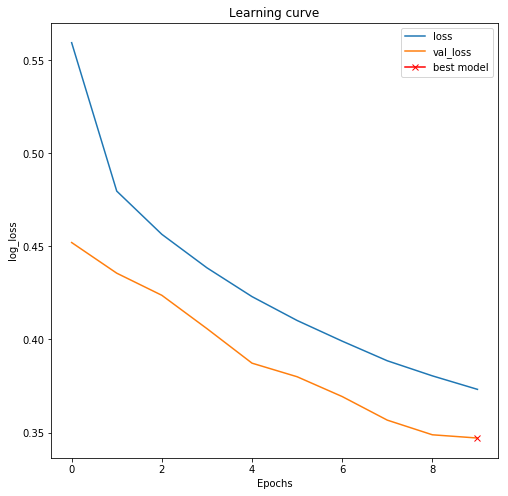

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Evaluation on test data

In [11]:
testX = np.array([x/255 for x in test_imgs])
testY = np.array([x/255 for x in test_masks])

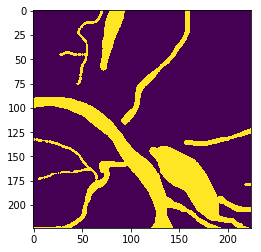

In [10]:
plt.imshow(np.squeeze(test_masks[0]))

In [11]:
scores = model.evaluate(test_imgs, test_masks, verbose=1)

24/24 [==============================] - 5s 212ms/step


In [12]:
print('Model loss = {}'.format(scores[0]))
print('Model accuracy = {}'.format(scores[1]))

Model loss = 0.3894241750240326
Model accuracy = 0.8576211929321289


## Test on unseen data
- create patches from one test image
- predict patches 
- compose predicted patches to result image

In [13]:
test_img = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk_data/imgs/Study_02_00010_04_R_registered.avi_average_image.tif')

In [14]:
import numpy as np
import math

### Functions for creating patches

In [15]:
def _fill_image(img, fill_up=0, fill_down=0, fill_left=0, fill_right=0):
        r = np.lib.pad(img[:, :, 0], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        g = np.lib.pad(img[:, :, 1], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        b = np.lib.pad(img[:, :, 2], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        changed_image = np.zeros((r.shape[0], r.shape[1], 3), 'uint8')
        changed_image[..., 0] = r
        changed_image[..., 1] = g
        changed_image[..., 2] = b
        return changed_image

def _modulo_image(img):
        h, w, ch = img.shape
        modulo_w = w % 224
        modulo_h = h % 224
        fill_w = 224 - modulo_w
        fill_h = 224 - modulo_h

        return _fill_image(img, fill_down=fill_h, fill_right=fill_w), \
               _fill_image(img, fill_down=fill_h, fill_right=fill_w).shape, math.ceil(w/224), math.ceil(h/224)

def _extract_blocks(img_or_mask, blocksize):
    M, N = img_or_mask.shape
    b0, b1 = blocksize
    return img_or_mask.reshape(M // b0, b0, N // b1, b1).swapaxes(1, 2).reshape(-1, b0, b1)

def _define_patches(img):
    r_patches = _extract_blocks(img[:, :, 0], (img_height, img_width))
    g_patches = _extract_blocks(img[:, :, 1], (img_height, img_width))
    b_patches = _extract_blocks(img[:, :, 2], (img_height, img_width))

    patched_images = []
    for patch in range(len(r_patches)):
        patched_image = np.zeros((r_patches[patch].shape[0], r_patches[patch].shape[1], 3), 'uint8')
        patched_image[..., 0] = r_patches[patch]
        patched_image[..., 1] = g_patches[patch]
        patched_image[..., 2] = b_patches[patch]
        patched_images.append(patched_image)

    return np.array(patched_images)/255

In [16]:
filled_img, dims, m_w, m_h = _modulo_image(test_img)
patched_img = _define_patches(filled_img)
np.array(patched_img).shape

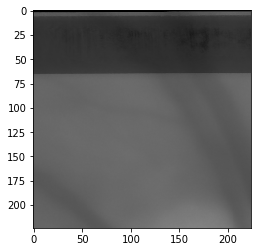

In [18]:
plt.imshow(patched_img[1])

### Composing image and mask from patches 

In [77]:
def compose_img(img_patches, image_dims, cnt_h, cnt_w, mode='mask'):
    if mode == 'mask':
        reconstructed_img = np.zeros((image_dims[0], image_dims[1], 1))
    elif mode == 'image':
        reconstructed_img = np.zeros((image_dims[0], image_dims[1], image_dims[2])) 
    ind_row = 0
    idx = 0
    for row in range(cnt_h): 
        ind_col = 0
        for col in range(cnt_w):
            reconstructed_img[ind_row:ind_row+224, ind_col:ind_col+224] = img_patches[idx]
            ind_col = ind_col + 224
            idx = idx + 1
        ind_row = ind_row + 224
    return reconstructed_img

In [20]:
rec_img = compose_img(patched_img, dims, m_h, m_w, mode='image')

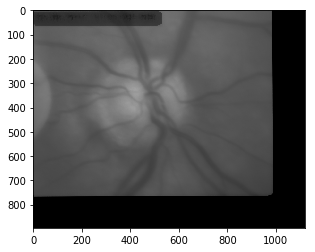

In [21]:
plt.imshow(rec_img)

### Predict test image

In [24]:
preds = model.predict(patched_img)

In [97]:
preds_t = (preds > 0.09)
prediction = np.squeeze(preds_t*1)
prediction.shape

In [100]:
rec_mask = compose_img(np.expand_dims(prediction, axis=-1), dims, m_h, m_w)
rec_mask.shape

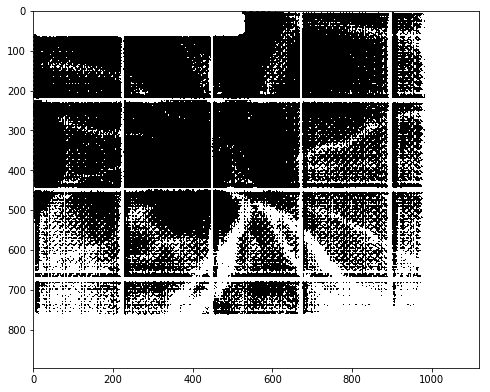

In [123]:
filtered_img =  medfilt2d(np.squeeze(rec_mask), 5)
plt.figure(figsize=(8,8))
plt.imshow(filtered_img, cmap='gray')

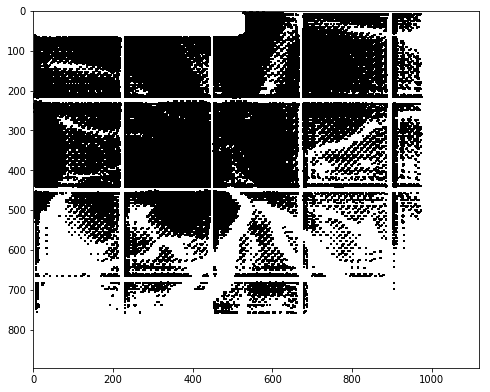

In [125]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(filtered_img, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(8,8))
plt.imshow(closing, cmap='gray')

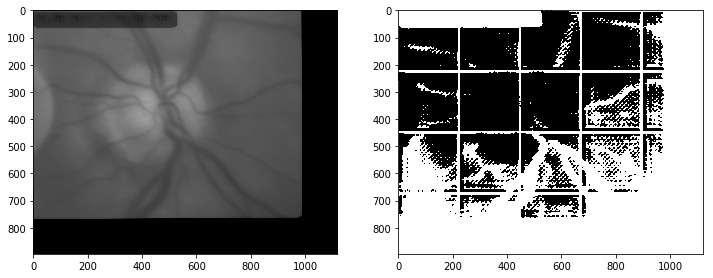

In [126]:
opening = medfilt2d(closing.astype(np.uint8), 5)
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(rec_img)
plt.subplot(122)
plt.imshow(opening, cmap='gray')